# Example - Kickstarter

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span><ul class="toc-item"><li><span><a href="#Feature-importance-migration" data-toc-modified-id="Feature-importance-migration-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Feature importance migration</a></span></li><li><span><a href="#Reverse-learning-curve" data-toc-modified-id="Reverse-learning-curve-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Reverse learning curve</a></span></li></ul></li><li><span><a href="#TRF-feature-importance-for-feature-selection" data-toc-modified-id="TRF-feature-importance-for-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF feature importance for feature selection</a></span></li><li><span><a href="#Feature-impact" data-toc-modified-id="Feature-impact-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature impact</a></span><ul class="toc-item"><li><span><a href="#Categoricals" data-toc-modified-id="Categoricals-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Categoricals</a></span></li></ul></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-designs-for-the-RF" data-toc-modified-id="Other-optimization-designs-for-the-RF-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Other optimization designs for the RF</a></span></li></ul></div>

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from time_robust_forest.models import TimeForestClassifier
#from models.time_robust_forest import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

# Loading and cleaning the data

In [4]:
DATASETS_PATH = "~/Documents/datasets/kickstarter/"

In [5]:
data = pd.read_csv(DATASETS_PATH + "ks-projects-201801.csv", engine="python")

In [6]:
#data = data.sample(frac=0.1)

In [7]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [8]:
data.shape

(378661, 15)

In [9]:
data.nunique()

ID                  378661
name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

In [10]:
data.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [11]:
print(data["launched"].min())
print(data["launched"].max())

1970-01-01 01:00:00
2018-01-02 15:02:31


In [12]:
print(data["deadline"].min())
print(data["deadline"].max())

2009-05-03
2018-03-03


In [13]:
data["launched"] = pd.to_datetime(data["launched"])
data["deadline"] = pd.to_datetime(data["deadline"])

In [14]:
data["Year"] = data["launched"].apply(lambda x: int(x.year))

In [15]:
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))

In [16]:
data["Year-Month"] = data["launched"].apply(lambda x: str(int(x.year)) + str(int(x.month)))

In [17]:
data["difference_launched_deadline"] = (data["deadline"] - data["launched"]).dt.days

## Create a target

In [18]:
data["state"].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [19]:
data["target"] = (data["state"] == "successful").astype(int)

In [20]:
data["target"].mean()

0.3537623362321443

## Modeling

### Data

In [21]:
TIME_COLUMN = "Year"
TARGET = "target"

In [22]:
columns_to_label_encode = ["country", 
                           "currency",
                           "category",
                           "main_category"]

In [23]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

country
currency
category
main_category


In [24]:
data["goal"] = data["goal"].astype(int)

In [25]:
features = ["goal"] + columns_to_label_encode

In [26]:
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: Year, dtype: int64

In [27]:
data = data[~data["Year"].isin([1970, 2018, 2009])]

In [28]:
data["Year"].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
Name: Year, dtype: int64

In [29]:
training_start_year = 2010
training_end_year = 2013
holdout_end_year = 2017

In [30]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [31]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)



In [32]:
test.shape

(24555, 19)

In [33]:
train.shape

(98217, 19)

In [34]:
out_of_time.shape

(254429, 19)

In [35]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

In [36]:
train[features]

,goal,country,currency,category,main_category
262406,1600,22,13,39,6
84676,35000,22,13,55,6
290580,12500,22,13,58,7
366566,20000,22,13,54,12
361597,2000,22,13,26,1
...,...,...,...,...,...
369808,15000,22,13,141,14
320026,3000,22,13,108,12
2644,3000,22,13,125,10
48740,30000,22,13,129,6


In [37]:
train[features].dtypes

goal             int64
country          int64
currency         int64
category         int64
main_category    int64
dtype: object

In [38]:
train[TARGET].dtypes

dtype('int64')

In [39]:
train.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'Year',
       'Year-Month', 'difference_launched_deadline', 'target'],
      dtype='object')

## Checking the support in the different environments

In [40]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2010    0.166667
2011    0.166667
2012    0.500000
2013    1.000000
Name: country, dtype: float64
Year
2010    0.2
2011    0.2
2012    0.4
2013    1.0
Name: currency, dtype: float64
Year
2010    0.493421
2011    0.559211
2012    0.710526
2013    0.973684
Name: category, dtype: float64
Year
2010    1.0
2011    1.0
2012    1.0
2013    1.0
Name: main_category, dtype: float64


0.6481359649122806

In [41]:
check_numerical_match(train, ["goal"], "Year")

Year
2010    0.222222
2011    0.333333
2012    0.666667
2013    0.777778
Name: goal_quant, dtype: float64


0.5

### Benchmark

In [42]:
from pycaret.classification import *

In [43]:
def reverse_learning_curve_by_sample(train, holdout, model, features, target, time_column, time_sort, performance_function, n_rounds=5):
    results = {"round": [], "holdout_performance": [], "sample_size": []}
    initial_size = int(len(train) / n_rounds)
    sample_sizes = np.linspace(initial_size, len(train), n_rounds, dtype=int)
    
    for sample_size in sample_sizes:
        
        model.fit(train.sort_values(time_sort, ascending=False).iloc[:sample_size][features + [time_column]].reset_index(inplace=False, drop=True), 
                  train.sort_values(time_sort, ascending=False).iloc[:sample_size][target].reset_index(inplace=False, drop=True))
        results["sample_size"].append(sample_size)
        performance = performance_function(holdout[target],
                                           model.predict_proba(holdout[features])[:, 1])
        results["holdout_performance"].append(performance)

    return results

In [44]:
def reverse_learning_curve(train, holdout, model, features, target, time_column, 
                           performance_function, n_rounds=5, trt_model=False, verbose=False):
    train_time_segments = np.sort(train[time_column].unique())[::-1]
    
    results = {"round": [], "holdout_performance": [], "feature_importance": [],
               "sample_size": [], "last_period_included": []}
    initial_size = int(len(train) / n_rounds)
    sample_sizes = np.linspace(initial_size, len(train), n_rounds, dtype=int)
    
    for nth, time_segment in enumerate(train_time_segments):
        if verbose: print(train_time_segments[:nth+1])
        if trt_model:
            model.fit(train[train[time_column].isin(train_time_segments[:nth+1])][features + [time_column]].reset_index(inplace=False, drop=True), 
            train[train[time_column].isin(train_time_segments[:nth+1])][target].reset_index(inplace=False, drop=True))
        else:
            model.fit(train[train[time_column].isin(train_time_segments[:nth+1])][features].reset_index(inplace=False, drop=True), 
            train[train[time_column].isin(train_time_segments[:nth+1])][target].reset_index(inplace=False, drop=True))
        
        sample_size = train[time_column].isin(train_time_segments[:nth+1]).sum()
        ### Feature Importance
        if trt_model:
            model_importances = model.feature_importance()
            
        else:
            model_importances = model.feature_importances_
            model_importances = pd.Series(model_importances, index=features)
            
        model_importances.rename(time_segment, inplace=True)
        results["feature_importance"].append(model_importances)
        
        results["sample_size"].append(sample_size)
        results["last_period_included"].append(time_segment)
        performance = performance_function(holdout[target],
                                           model.predict_proba(holdout[features])[:, 1])
        results["holdout_performance"].append(performance)

    return results

In [45]:
def plot_shap_difference(importance, mode="rank", rotate=False, title=None, cmap=None, threshold=0):
    """
    Compares shap importances between multiple groups
    Parameters
    ----------
    df : pandas.DataFrame
        Dataset containing the importances, with features as index, and each column corresponding to a specific group.
    mode : string
        If "rank", the plot will use ranks, else actual shap importances 
    rotate : boolean
        Rotates x axis labels
    title : str 
        Title of the plot to be displayed
    cmap : cmap
        A cmap to be used by plot
    """
    from matplotlib.pyplot import get_cmap
    
    if cmap is None:
        cmap = get_cmap('viridis')
    
    fig, ax1 = plt.subplots(figsize=(3,6), dpi=150)
    ax2 = ax1.twinx()
    
    df = importance
    df = df[df.max(axis=1) > threshold]
    if mode == 'rank': 
        df = df.rank(axis=0, ascending=False, method='first')
        df = df.max().max() - df
    df = df.sort_values(by=df.columns[0])

    ids = pd.DataFrame({"group": df.index}).reset_index().groupby("group").transform("count").rank(method='first')
    ids = ids.apply(lambda x: cmap((x["index"] - 1) / (len(ids["index"].unique())-1)), axis=1)
    
    rot = 0;
    if rotate:
        rot = 90;

    df.transpose().plot(legend=False, rot=rot,
                        ax=ax1, color=ids, linewidth=10, alpha=0.5);

    if mode == 'rank':
        ax1.yaxis.set_ticks(df[df.columns[0]]);
        ax1.set_yticklabels(df.index);

        df = df.sort_values(by=df.columns[-1])
        ax2.set_ybound(ax1.get_ybound());
        ax2.yaxis.set_ticks(df[df.columns[-1]]);
        ax2.set_yticklabels(df.index);
    else:
        bound = ax1.get_ybound()
        mindist = (bound[1] - bound[0]) * 0.01

        df = df.sort_values(by=df.columns[0])
        diff = abs(df.diff()).fillna(1)
        df_left = df[diff[df.columns[0]] > mindist]
        ax1.yaxis.set_ticks(df_left[df_left.columns[0]]);
        ax1.set_yticklabels(df_left.index);

        df = df.sort_values(by=df.columns[-1])
        diff = abs(df.diff()).fillna(1)
        df_right = df[diff[df.columns[-1]] > mindist]
        ax2.set_ybound(bound);
        ax2.yaxis.set_ticks(df_right[df_right.columns[-1]]);
        ax2.set_yticklabels(df_right.index);
        
    for c in df.columns:
        plt.axvline(x=c, color='lightgrey', linestyle='--');
    
    if title is None:
        plt.title("Importance by group")
    else:
        plt.title(title)


In [46]:
clf1 = setup(train[features + [TARGET]], target="target",
             session_id=1,
             log_experiment=False,
             experiment_name="kickstarter",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6426,0.6894,0.4872,0.6217,0.5463,0.2586,0.2638
1,0.6491,0.6970,0.4857,0.6341,0.5500,0.2706,0.2771
2,0.6499,0.6967,0.5105,0.6273,0.5629,0.2760,0.2801
3,0.6462,0.6930,0.4850,0.6289,0.5477,0.2650,0.2710
4,0.6456,0.6877,0.5362,0.6128,0.5720,0.2719,0.2736
Mean,0.6467,0.6927,0.5009,0.6249,0.5558,0.2684,0.2731
SD,0.0026,0.0038,0.0201,0.0072,0.0100,0.0060,0.0056


In [47]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=8, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [48]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [49]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.7002353698829513
0.6883284829068772
0.619902268916518


In [50]:
benchmark_model = RandomForestClassifier(n_estimators=140, max_depth=4)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [51]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.6784592206615705
0.671453055423226
0.6404481803461431


In [52]:
explainer = shap.Explainer(benchmark_model)

In [53]:
shap_values = explainer(out_of_time[features])[:, :, 1]

In [54]:
shap_values.shape

(254429, 5)

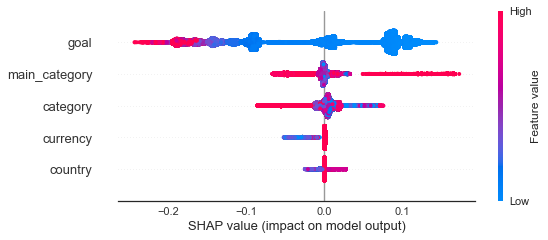

In [55]:
shap.plots.beeswarm(shap_values)

The SHAP capability is not implemented in the TimeRobustForest.

In [56]:
benchmark_importances = benchmark_model.feature_importances_
benchmark_importances = pd.Series(benchmark_importances, index=features)
benchmark_importances.rename("RF", inplace=True)

goal             0.723905
country          0.004566
currency         0.009005
category         0.089394
main_category    0.173130
Name: RF, dtype: float64

In [57]:
results = reverse_learning_curve(train, out_of_time, benchmark_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

In [58]:
def plot_feature_migration_from_learning_curve_results(results, features):
    all_times_importance = pd.DataFrame(index=features)
    for imp in results["feature_importance"]:
        all_times_importance = all_times_importance.merge(imp, how="left", left_index=True, 
                                right_index=True)

    plot_shap_difference(all_times_importance, title="Feature importance migration from the reverse learning curve")
    
    return all_times_importance

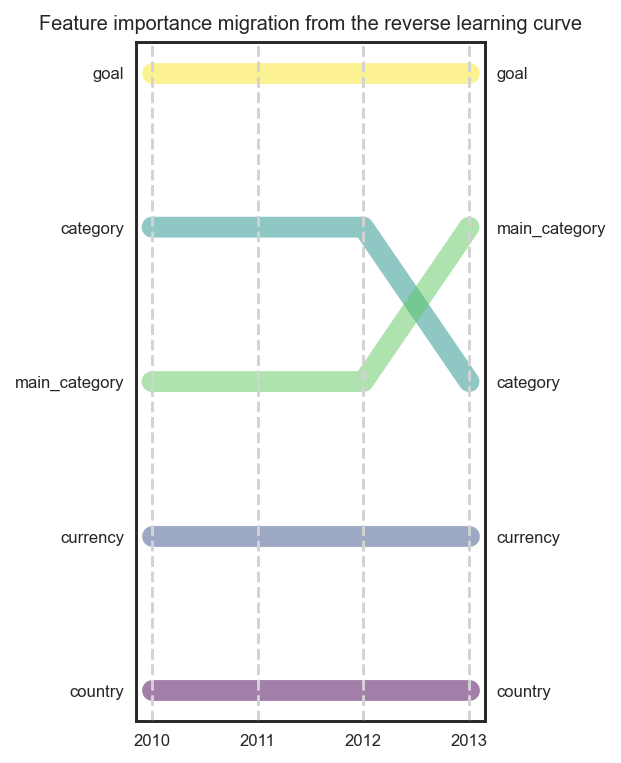

In [59]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features)

In [60]:
importance_by_reverse_segment_benchmark

,2013,2012,2011,2010
goal,0.666769,0.689216,0.697843,0.743874
country,0.017574,0.007522,0.005789,0.004283
currency,0.028092,0.011392,0.009729,0.010064
category,0.160731,0.130955,0.111355,0.089211
main_category,0.126834,0.160914,0.175284,0.152568


## Challenger model

In [61]:
#train = pd.concat([train, train[train["Year"] == 2010].sample(1200, replace=True)])

In [62]:
train.reset_index(drop=True, inplace=True)

In [63]:
train[features + [TIME_COLUMN]]

,goal,country,currency,category,main_category,Year
0,1600,22,13,39,6,2011
1,35000,22,13,55,6,2011
2,12500,22,13,58,7,2012
3,20000,22,13,54,12,2013
4,2000,22,13,26,1,2012
...,...,...,...,...,...,...
98212,15000,22,13,141,14,2012
98213,3000,22,13,108,12,2010
98214,3000,22,13,125,10,2011
98215,30000,22,13,129,6,2012


In [64]:
train["Year"].value_counts()

2013    35832
2012    32953
2011    21052
2010     8380
Name: Year, dtype: int64

In [65]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=60,
                                        min_sample_periods=150,
                                        max_depth=4,
                                        period_criterion='max',
                                        multi=True)
challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [66]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.675446400490493
0.6676483417162671
0.6401779704034745


In [67]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

goal             186
main_category    136
category         121
LEAF               5
Name: TRF Max, dtype: int64

In [68]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=60,
                                        min_sample_periods=150,
                                        max_depth=4,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [69]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.6745959283914211
0.6664930387119302
0.6403805157157585


### Feature importance migration

In [70]:
challenger_model_importances = challenger_model.feature_importance()
challenger_model_importances.rename("TRF", inplace=True)

goal             166
main_category    123
category         106
LEAF               5
Name: TRF, dtype: int64

In [71]:
all_models_importance = pd.DataFrame(index=features)

In [72]:
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

,RF,TRF,TRF Max
goal,0.723905,166.0,186.0
country,0.004566,0.0,0.0
currency,0.009005,0.0,0.0
category,0.089394,106.0,121.0
main_category,0.173130,123.0,136.0


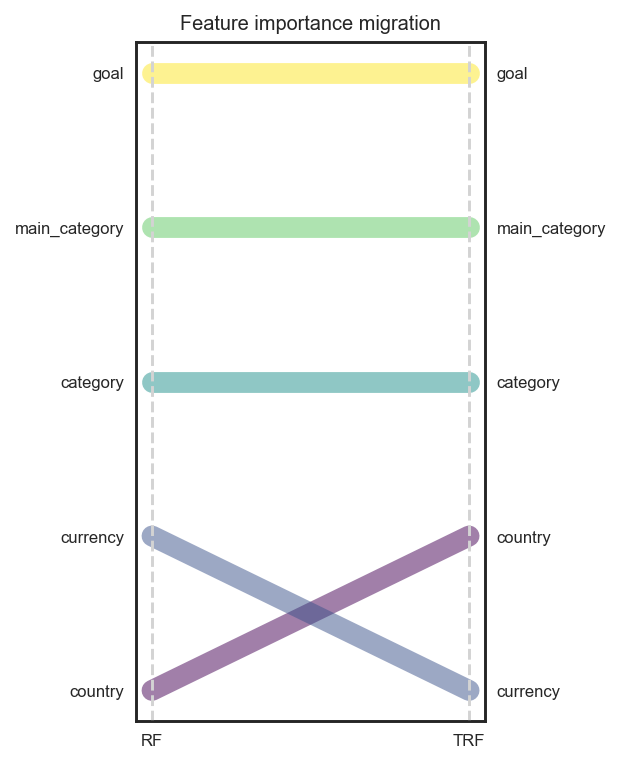

In [73]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="Feature importance migration")

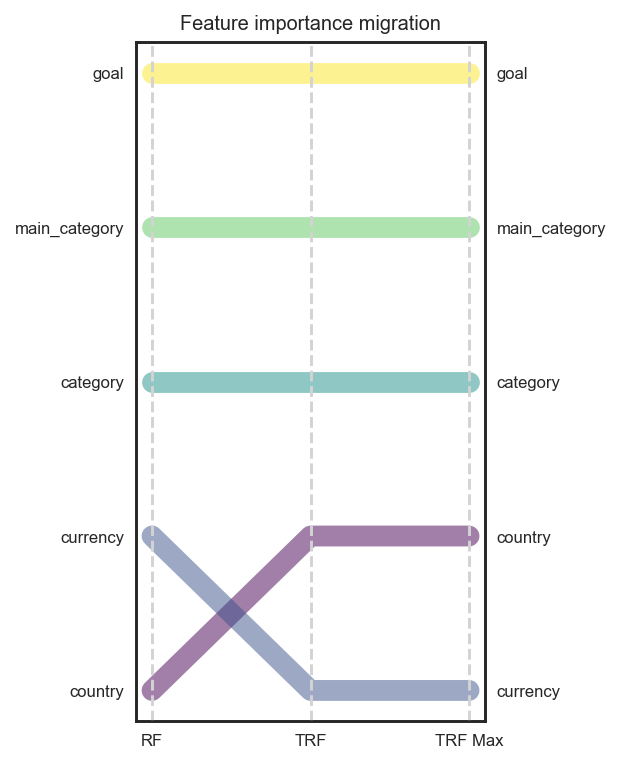

In [74]:
plot_shap_difference(all_models_importance, title="Feature importance migration")

### Reverse learning curve

In [75]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=60,
                                        min_sample_periods=150,
                                        max_depth=4,
                                        multi=True)

In [76]:
results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

,2013,2012,2011,2010
goal,277,225,214.0,169.0
country,92,17,NaN,NaN
currency,48,21,NaN,NaN
category,170,133,130.0,104.0
main_category,155,157,149.0,133.0


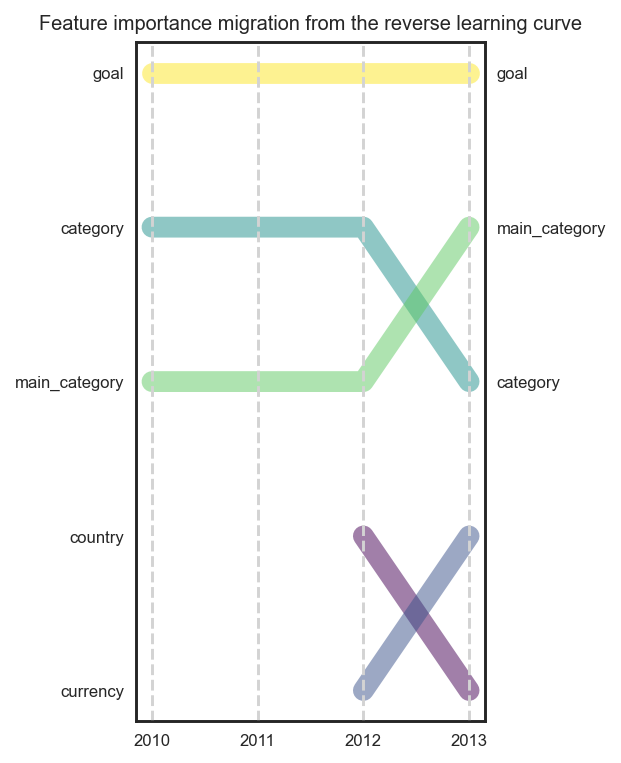

In [77]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features)
importance_by_reverse_segment_challenger

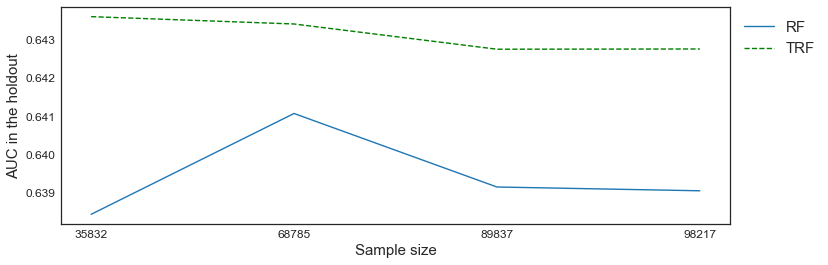

In [78]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/kickstarter_reverse_learning_curve_sample.eps", format="eps")
plt.show()

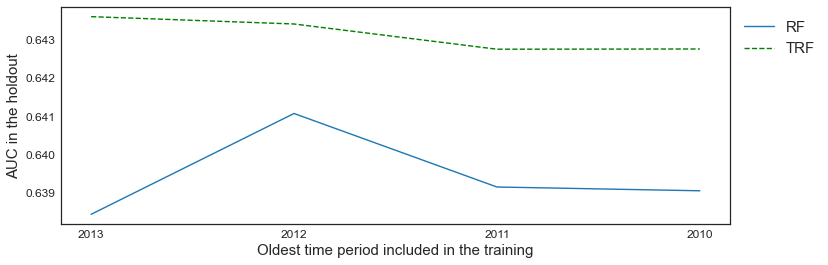

In [79]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/kickstarter_reverse_learning_curve_segments.eps", format="eps")
plt.show()

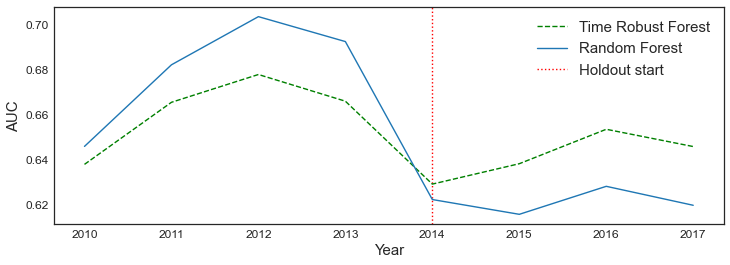

In [80]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/kickstarter_test_holdout_auc_years.eps", format="eps")
plt.show()

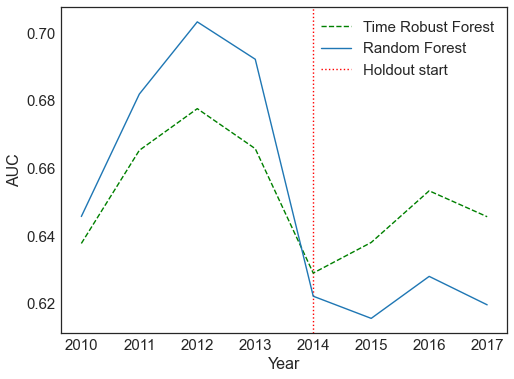

In [81]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/kickstarter_test_holdout_auc_years_square.eps", format="eps")
plt.show()

In [82]:
#pd.concat([test, out_of_time])[[TIME_COLUMN, "benchmark_prediction", "benchmark_prediction_opt", "challenger_prediction"]].to_csv("results/7_kickstarter_example.csv")

## TRF feature importance for feature selection

In [83]:
challenger_model.feature_importance()

goal             169
main_category    133
category         104
LEAF               6
Name: Feature Importance, dtype: int64

In [84]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['goal', 'category', 'main_category']

In [85]:
clf1 = setup(train[selected_features + [TARGET]], target="target",
             session_id=2,
             log_experiment=False,
             experiment_name="kickstarter_selected",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6445,0.6963,0.6743,0.5817,0.6246,0.2905,0.2934
1,0.6436,0.6946,0.6320,0.5869,0.6086,0.2822,0.2829
2,0.6430,0.6962,0.6420,0.5847,0.6120,0.2827,0.2838
3,0.6441,0.6978,0.6486,0.5850,0.6152,0.2857,0.2871
4,0.6413,0.6976,0.6521,0.5812,0.6146,0.2812,0.2829
Mean,0.6433,0.6965,0.6498,0.5839,0.6150,0.2845,0.2860
SD,0.0011,0.0012,0.0141,0.0021,0.0053,0.0034,0.0040


In [86]:
tuned_rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=9, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=-1, oob_score=False,
                       random_state=2, verbose=0, warm_start=False)

In [87]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [88]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.7074186454799024
0.692962793468207
0.6102192885596466


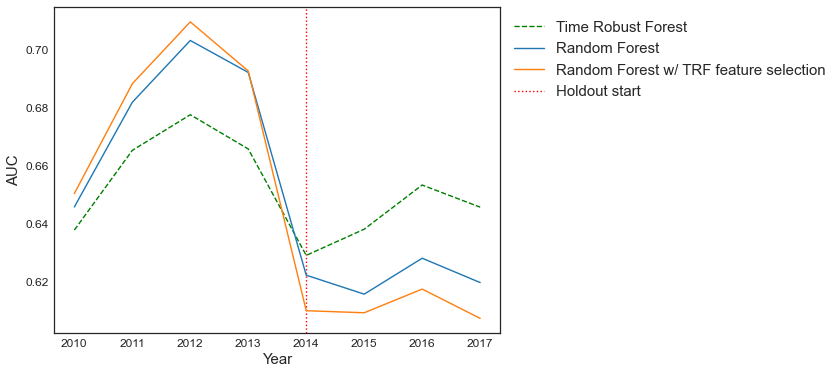

In [89]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/kickstarter_test_holdout_auc_years_fs.eps", format="eps")
plt.show()

## Feature impact

In [90]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

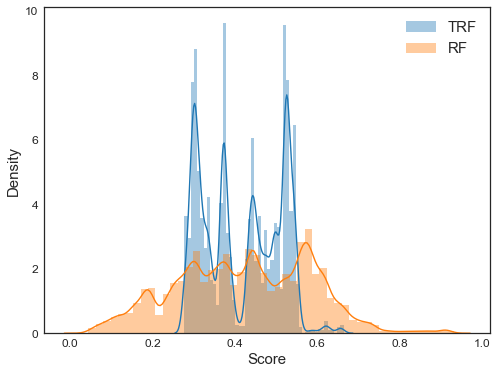

In [93]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/kickstarter_trf_rf_score_distribution"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

#plt.savefig("../images/kickstarter_trf_rf_score_distribution.eps", format="eps")
plt.show()

In [94]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

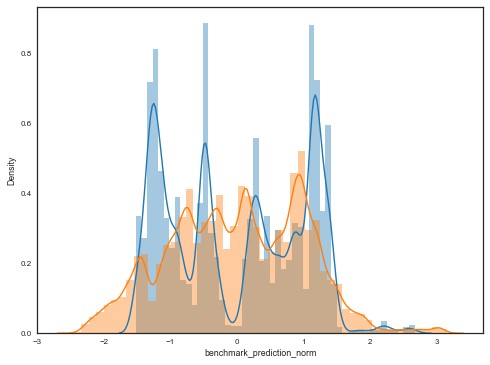

In [95]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [96]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction_norm", 
                                                                 "benchmark_prediction_norm"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(101771, 5)
(152658, 5)


Treat outliers

In [97]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]

In [98]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [99]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction_norm"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction_norm"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:43 Time:  0:00:43
100% (11 of 11) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


In [100]:
pred_test = gam_challenger.predict(X_test[features])
print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction_norm"], pred_test))

pred_test = gam_benchmark.predict(X_test[features])
print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction_norm"], pred_test))

r2 test (challenger): 0.962167
r2 test (benchmark): 0.801190


goal


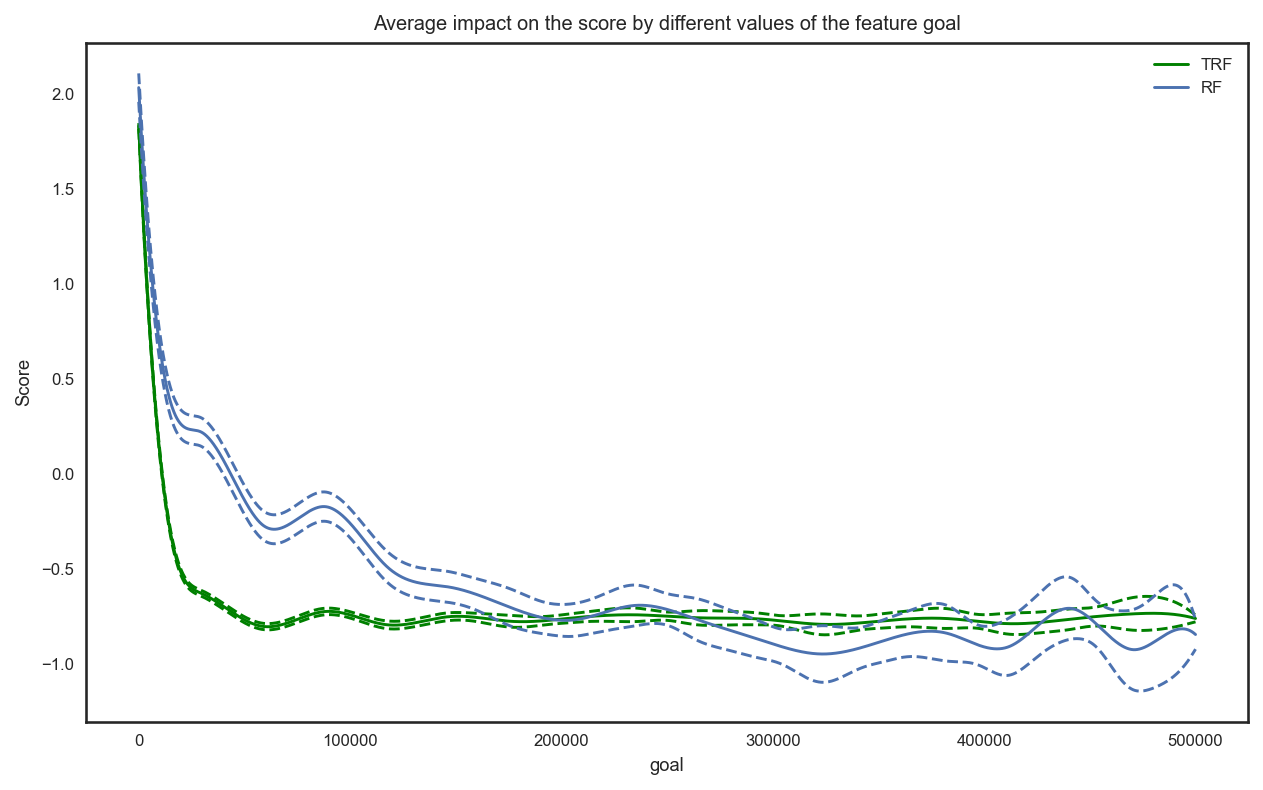

<Figure size 576x432 with 0 Axes>

In [101]:
for i, feat in enumerate(numerical_features):
    print(feat)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    #pdb.set_trace()
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    #plt.plot(XX[:, i], confi, c='green', ls='--', label="95% interval")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()
    
    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    #fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    #plt.plot(XX[:, i], confi, c='', ls='--', label="95% interval")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.title("Average impact on the score by different values of the feature {}".format(feat))    
    plt.ylabel("Score")
    plt.legend()
    
    plt.xlabel(feat)
    
    
    plt.show()
    plt.clf()

### Categoricals

country


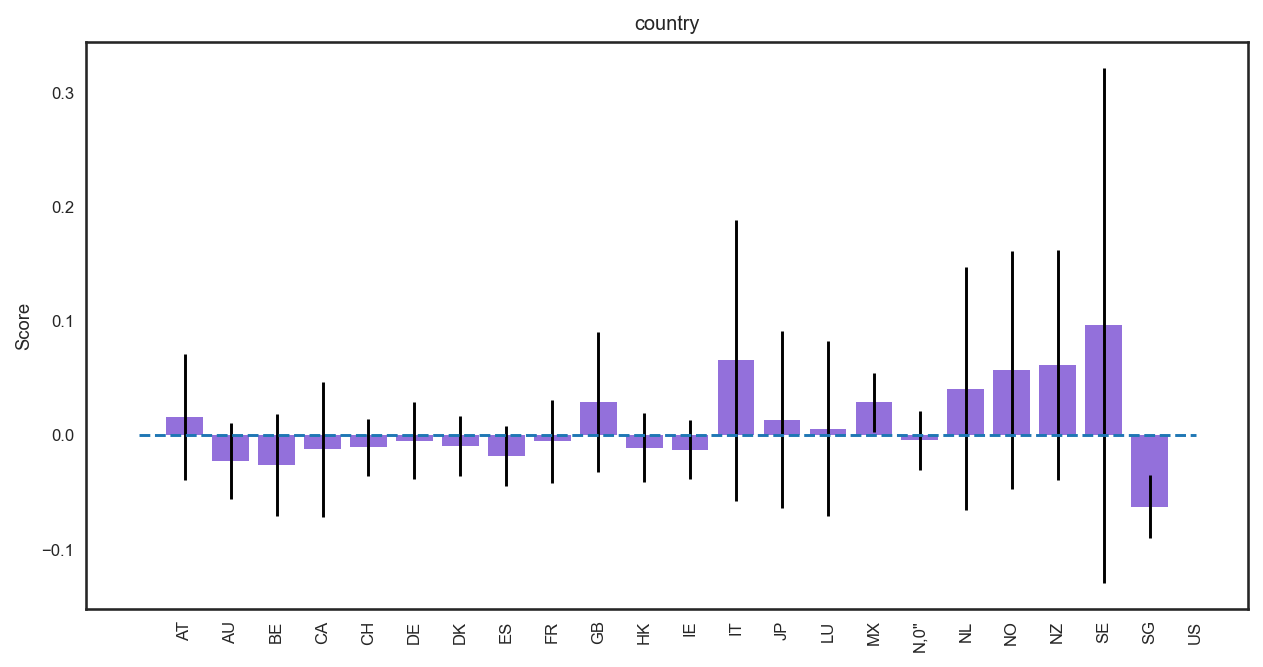

currency


<Figure size 576x432 with 0 Axes>

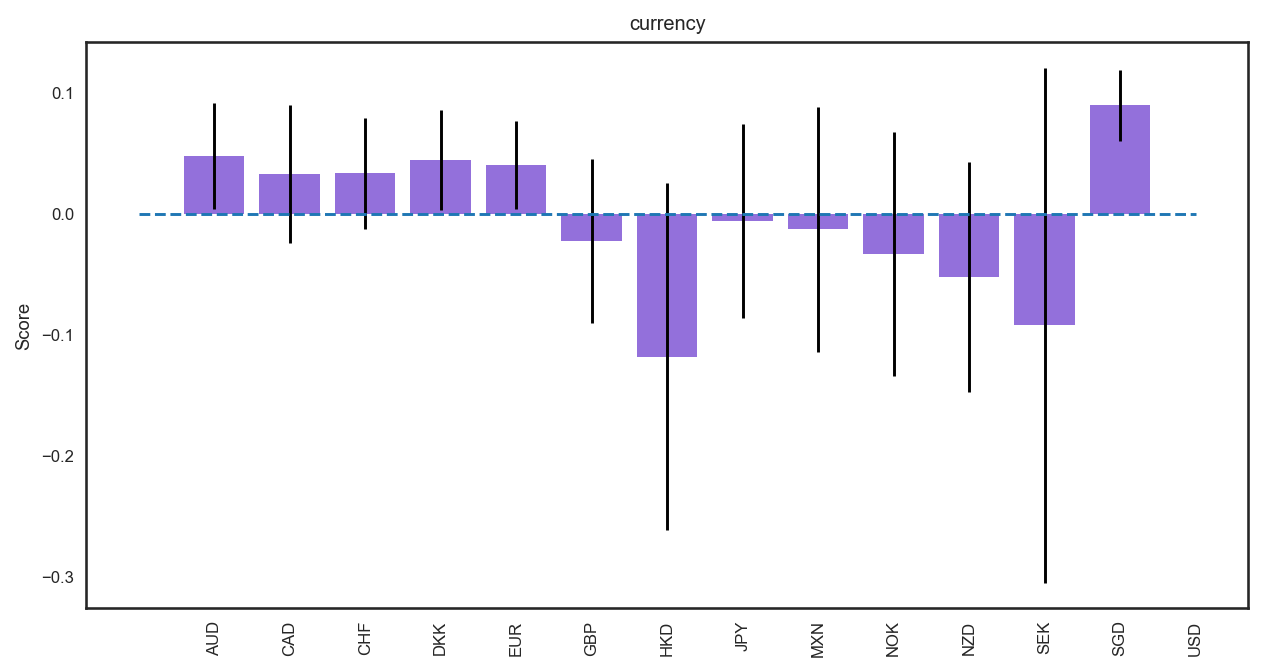

category


<Figure size 576x432 with 0 Axes>

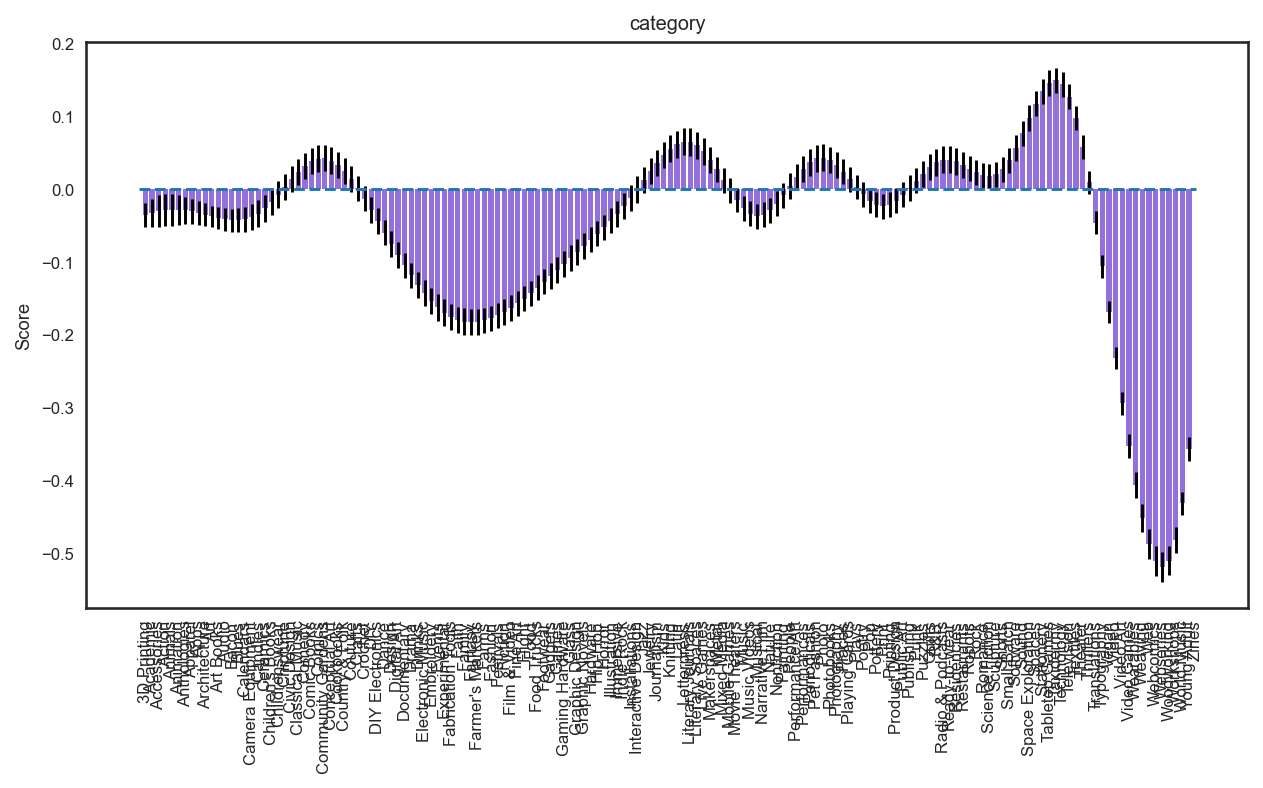

main_category


<Figure size 576x432 with 0 Axes>

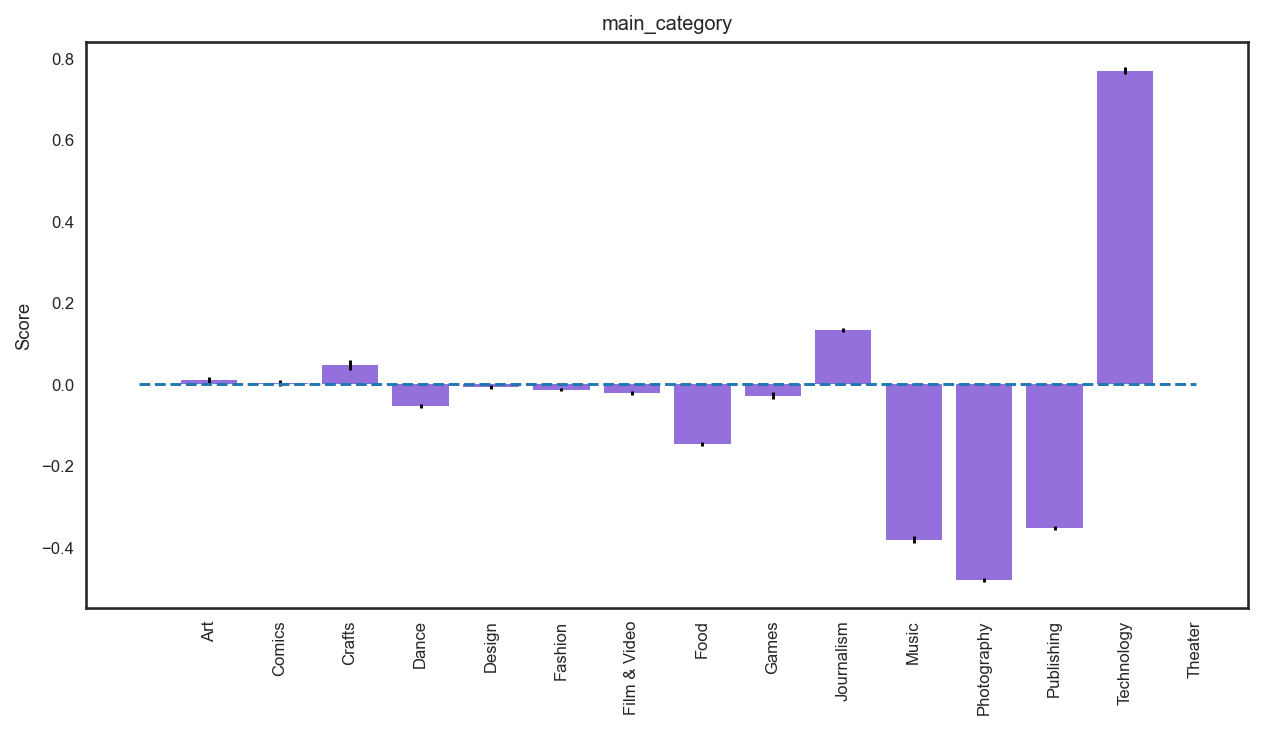

<Figure size 576x432 with 0 Axes>

In [102]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(1, max_cat+1, size=X_test.shape[0])
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score")
        plt.show()
        plt.clf()

In [103]:
import seaborn as sns

country


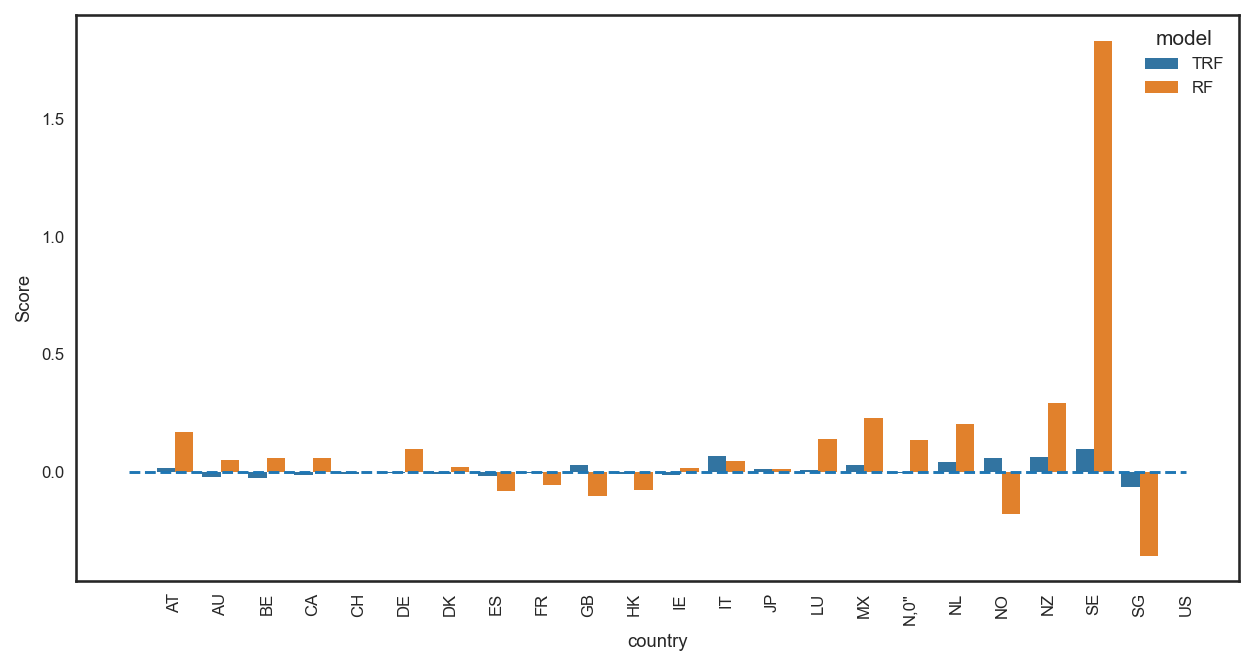

currency


<Figure size 576x432 with 0 Axes>

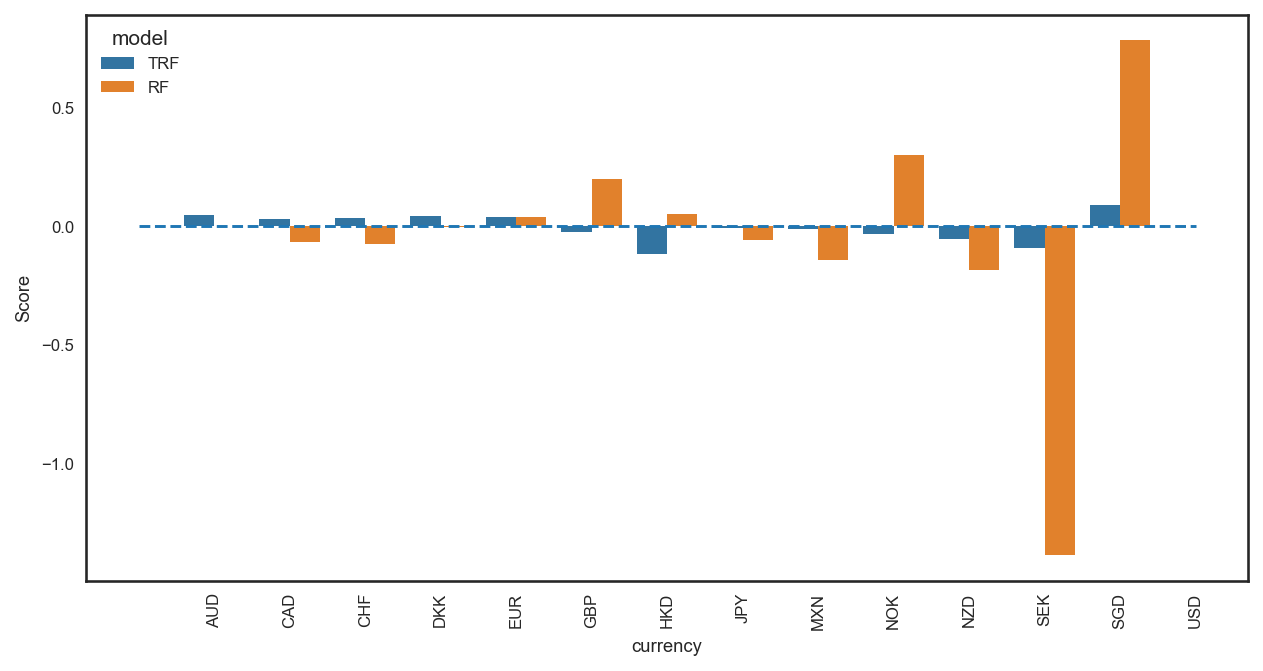

category


<Figure size 576x432 with 0 Axes>

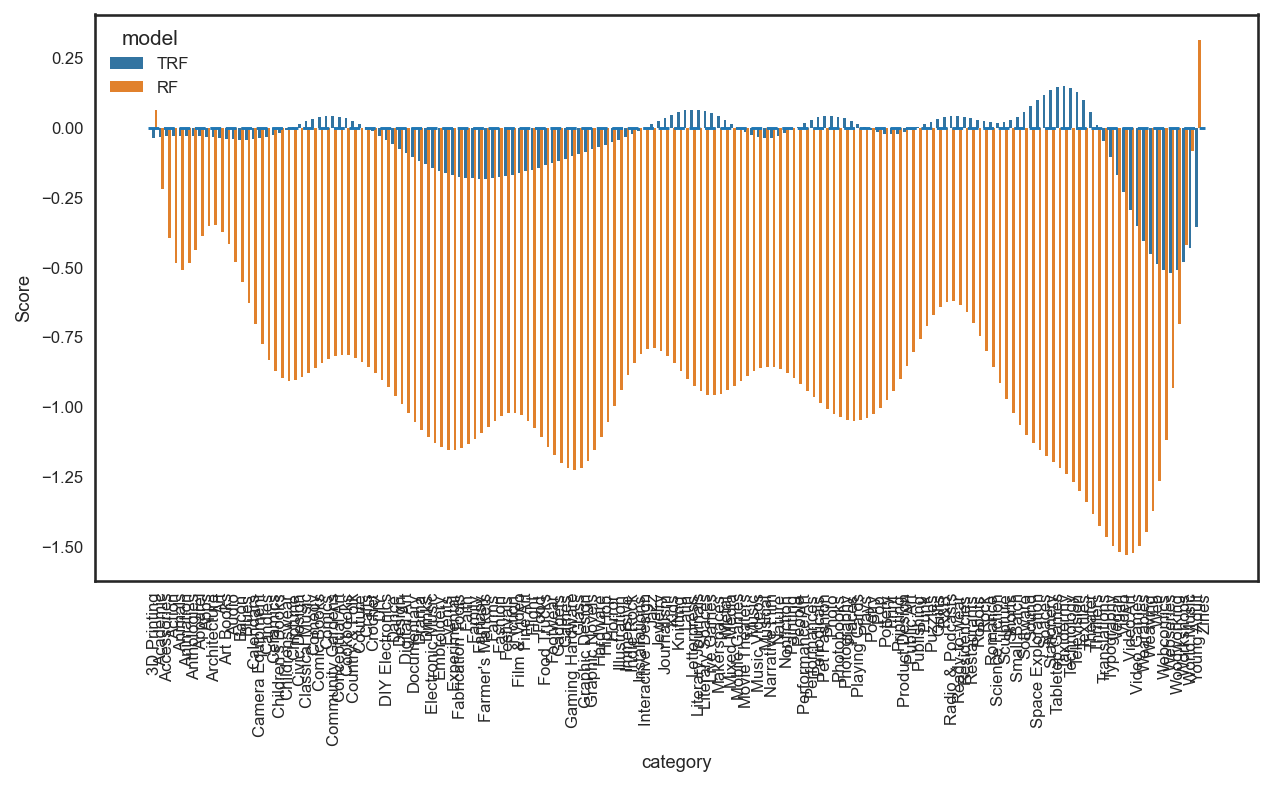

main_category


<Figure size 576x432 with 0 Axes>

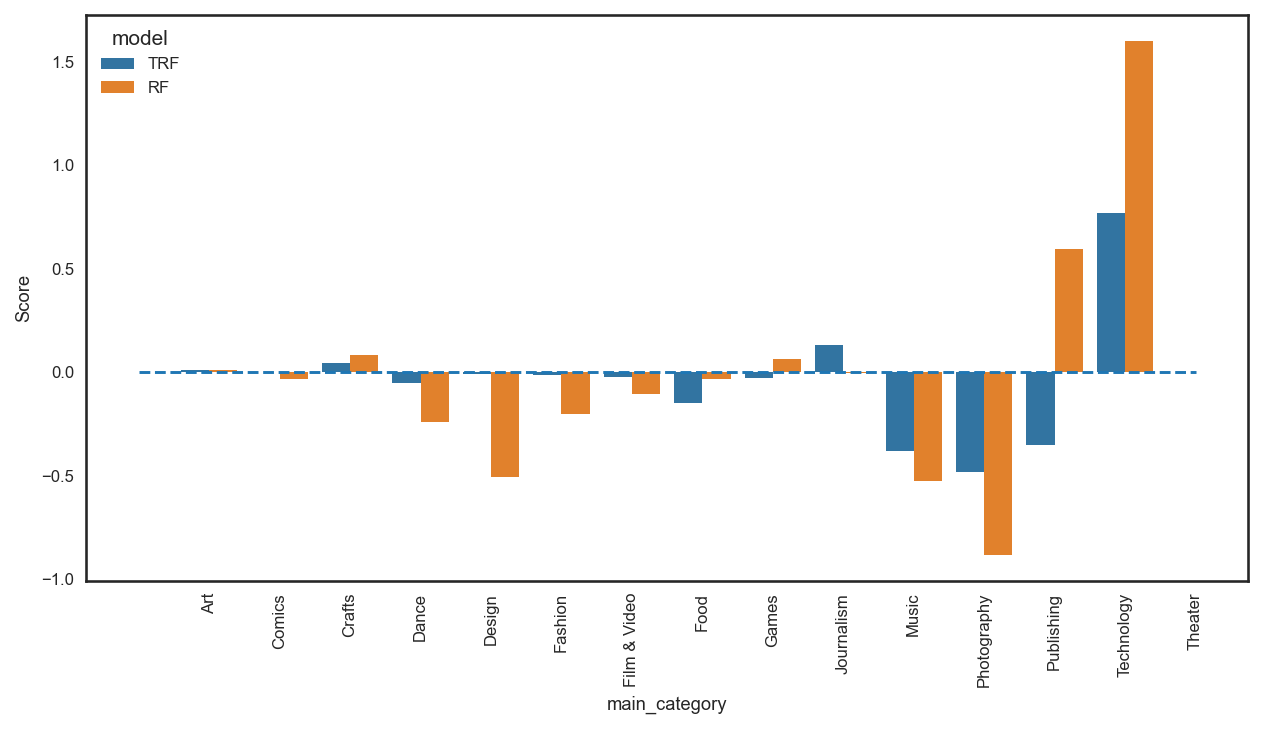

<Figure size 576x432 with 0 Axes>

In [104]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(1, max_cat+1, size=X_test.shape[0])
        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        #fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")

        
#         impact_plot = plt.bar([i for i in range(len(agg))],
#                       agg["Mean Impact"],
#                       yerr=agg[["low", "high"]].values.transpose(),
#                       color="#9370DB",
#                       capsize=7)

#         plt.title(feat)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score")
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [105]:
from sklearn import metrics

In [106]:
MAX_DEPTH = 10
target = TARGET

In [107]:
min_sample_periods_values = [i for i in range(5, 501, 50)] + [550, 650, 750, 850, 1000]

In [108]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=60,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

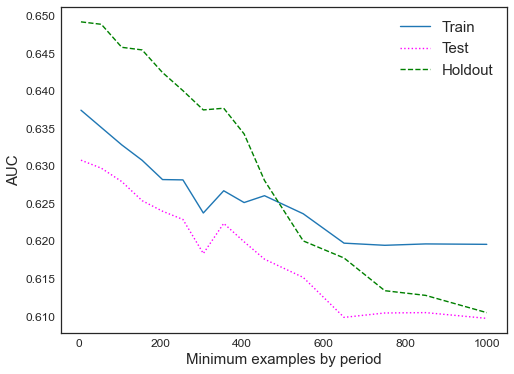

In [109]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/kickstarter_test_min_example_by_period_train_and_holdout_whole.eps", format="eps")
plt.show()

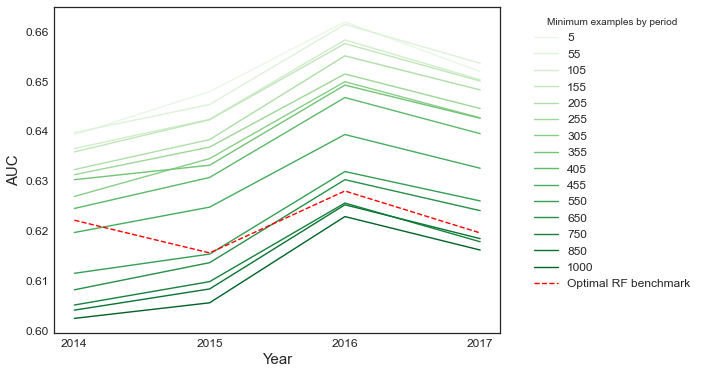

In [110]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/kickstarter_holdout_dif_min_samples.eps", format="eps", bbox_inches = "tight")
plt.show()

In [111]:
np.sort(out_of_time[TIME_COLUMN].unique())

array([2014, 2015, 2016, 2017])

In [112]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

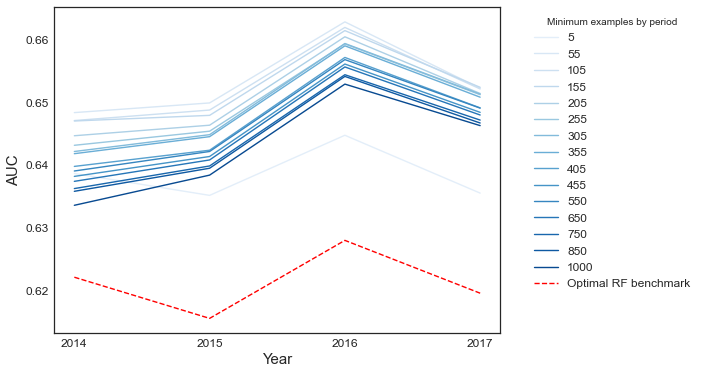

In [113]:
#min_sample_periods_values = [i for i in range(5, 501, 50)] + [550, 650, 750, 850, 1000]
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/kickstarter_holdout_dif_min_samples_benchmark.eps", format="eps", bbox_inches = "tight")
plt.show()

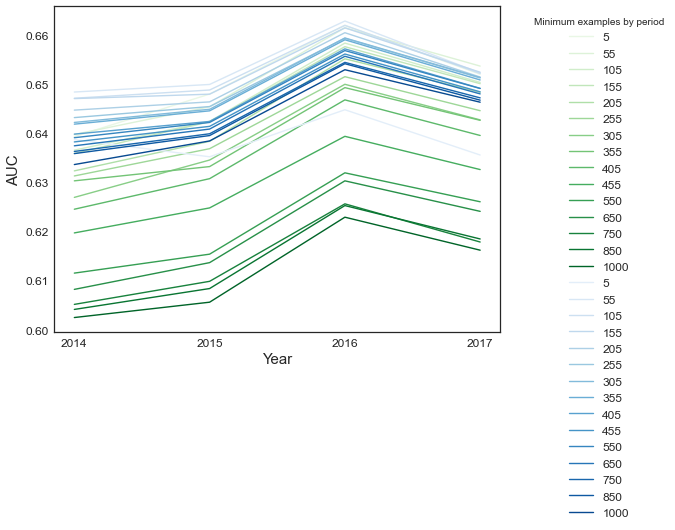

In [126]:
#min_sample_periods_values = [i for i in range(5, 501, 50)] + [550, 650, 750, 850, 1000]
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/kickstarter_holdout_dif_min_samples_benchmark_challenger.eps", format="eps", bbox_inches = "tight")
plt.show()

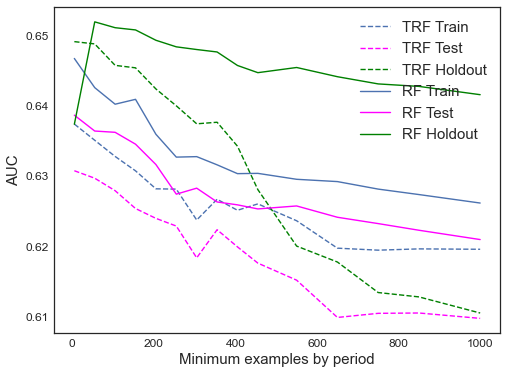

In [115]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/kickstarter_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps", format="eps")
plt.show()

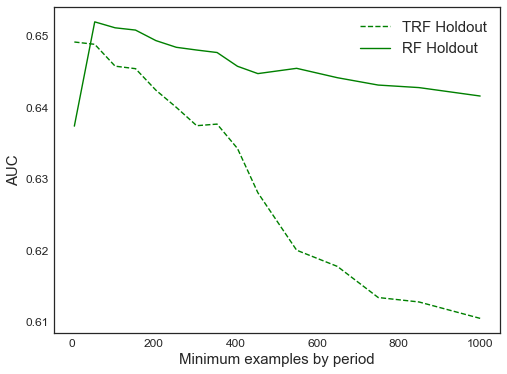

In [116]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/kickstarter_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps", format="eps")
plt.show()

## Domain classifier

In [117]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [118]:
domain_data = pd.concat([train, test, out_of_time])

In [119]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)



In [120]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=123, 
             log_experiment=False, 
             experiment_name="kickstarter_domain",
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7570,0.8299,0.4805,0.6815,0.5636,0.4022,0.4139
1,0.7528,0.8251,0.4712,0.6737,0.5546,0.3908,0.4027
2,0.7552,0.8218,0.4961,0.6688,0.5697,0.4038,0.4126
3,0.7528,0.8258,0.4704,0.6742,0.5542,0.3906,0.4027
4,0.7528,0.8236,0.4736,0.6726,0.5558,0.3916,0.4032
Mean,0.7541,0.8252,0.4784,0.6742,0.5596,0.3958,0.4070
SD,0.0017,0.0027,0.0095,0.0041,0.0061,0.0059,0.0051


In [121]:
domain_model = tuned_domain_rf

In [122]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=11, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=140,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [123]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [124]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.8431863913017777

In [125]:
#.78

## Other optimization designs for the RF

In [134]:
new_train = in_time[in_time["Year"] < 2013]
new_validation = in_time[in_time["Year"] == 2013]

In [135]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=3,
             log_experiment=False,
             experiment_name="kickstarter_opt1",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6438,0.7018,0.6627,0.5884,0.6233,0.2877,0.2896
1,0.6468,0.7003,0.6635,0.5918,0.6256,0.2934,0.2951
2,0.6425,0.6964,0.6609,0.5870,0.6218,0.2850,0.2868
3,0.6509,0.7062,0.6667,0.5961,0.6294,0.3014,0.3031
4,0.6476,0.6985,0.6652,0.5924,0.6267,0.2951,0.2969
5,0.6502,0.7018,0.6616,0.5962,0.6272,0.2993,0.3008
6,0.6444,0.7005,0.6673,0.5884,0.6254,0.2895,0.2915
7,0.6498,0.7038,0.6561,0.5967,0.6250,0.2978,0.2990
8,0.6523,0.7131,0.6691,0.5975,0.6313,0.3044,0.3061
9,0.6434,0.6997,0.6567,0.5889,0.6209,0.2861,0.2876


In [136]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [137]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_2013"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_2013"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_2013"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [130]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [131]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=2,
             log_experiment=False,
             experiment_name="kickstarter_opt2",
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6354,0.7012,0.7312,0.5682,0.6395,0.2822,0.2914
1,0.6253,0.6890,0.7105,0.5602,0.6265,0.2610,0.2685
2,0.6363,0.7000,0.7228,0.5700,0.6374,0.2826,0.2907
3,0.6390,0.6959,0.7055,0.5748,0.6335,0.2850,0.2908
4,0.6390,0.7005,0.7118,0.5741,0.6355,0.2859,0.2924
5,0.6345,0.6934,0.7280,0.5676,0.6379,0.2801,0.2890
6,0.6476,0.7093,0.7128,0.5832,0.6415,0.3018,0.3077
7,0.6460,0.6999,0.6821,0.5857,0.6302,0.2945,0.2976
8,0.6450,0.6879,0.5525,0.6087,0.5793,0.2735,0.2744
9,0.6383,0.6869,0.5214,0.6059,0.5605,0.2562,0.2582


In [ ]:
tuned_rf

In [132]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_2013"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_2013"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_2013"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

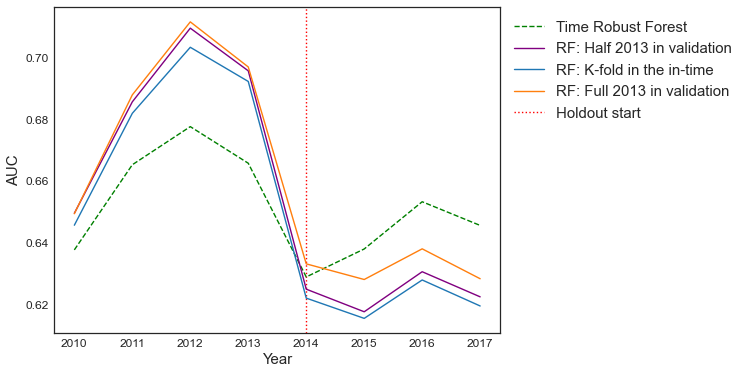

In [143]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_2013"])).plot(label="RF: Half 2013 in validation", 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_2013"])).plot(label="RF: Full 2013 in validation", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/kickstarter_performance_proof.eps", format="eps", bbox_inches = "tight")
plt.show()